In [80]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from matplotlib import pyplot as plt
import tokenize
import io
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import display, HTML
import lime
from lime.lime_text import LimeTextExplainer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import keras_tuner as kt
import json
import pickle
from tensorflow.keras.utils import plot_model

In [81]:
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Embedding, Conv1D, GlobalMaxPooling1D, GlobalAveragePooling1D, LSTM, SimpleRNN, SpatialDropout1D, Attention, MaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping , ModelCheckpoint
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [82]:
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [83]:
df_code_py = pd.read_parquet('df_code_py.gzip')

In [84]:
df_code_py.head()

,academic_year_1,task,user,date,academic_year_0,upload,module,correct,hour_submitted,tokens,token_count,line_count,token_code_only,token_per_line
0,2017,add.py,b9e7e608-6036-4d44-8770-a7036176b53c,2016-09-19 14:11:41,2016,#!/usr/bin/env python\n\na = int(raw_input())\...,ca277,True,14,"[{'end': [1, 21], 'line': '#!/usr/bin/env pyth...",30,4,"[\n, a, =, int, (, raw_input, (, ), ), \n, b, ...",7.5
1,2017,concat-lines.py,b9e7e608-6036-4d44-8770-a7036176b53c,2016-09-19 14:17:33,2016,#!/usr/bin/env python\n\na = str(raw_input())\...,ca277,True,14,"[{'end': [1, 21], 'line': '#!/usr/bin/env pyth...",30,4,"[\n, a, =, str, (, raw_input, (, ), ), \n, b, ...",7.5
2,2017,goodbye.py,b9e7e608-6036-4d44-8770-a7036176b53c,2016-09-19 10:15:59,2016,"#!/usr/bin/env python\n\nprint ""Goodbye""\n",ca277,True,10,"[{'end': [1, 21], 'line': '#!/usr/bin/env pyth...",7,2,"[\n, print, ""Goodbye"", \n]",3.5
3,2017,less-than.py,b9e7e608-6036-4d44-8770-a7036176b53c,2016-09-19 14:14:22,2016,#!/usr/bin/env python\n\na = int(raw_input())\...,ca277,True,14,"[{'end': [1, 21], 'line': '#!/usr/bin/env pyth...",30,4,"[\n, a, =, int, (, raw_input, (, ), ), \n, b, ...",7.5
4,2017,longest-line.py,b9e7e608-6036-4d44-8770-a7036176b53c,2016-09-19 14:51:28,2016,#!usr/bin/evn python\n\na = raw_input()\nb = r...,ca277,True,14,"[{'end': [1, 20], 'line': '#!usr/bin/evn pytho...",42,7,"[\n, a, =, raw_input, (, ), \n, b, =, raw_inpu...",6.0


In [85]:
df_code_py.shape

(378455, 14)

In [86]:
df_code_py_exp = df_code_py
#df_code_py_exp = df_code_py[df_code_py["task"]=="ex3-first-long-word.py"]

In [87]:
df_code_py_exp.iloc[0].tokens

array([{'end': array([ 1, 21], dtype=int64), 'line': '#!/usr/bin/env python\n', 'start': array([1, 0], dtype=int64), 'string': '#!/usr/bin/env python', 'type': 61},
       {'end': array([ 1, 22], dtype=int64), 'line': '#!/usr/bin/env python\n', 'start': array([ 1, 21], dtype=int64), 'string': '\n', 'type': 62},
       {'end': array([2, 1], dtype=int64), 'line': '\n', 'start': array([2, 0], dtype=int64), 'string': '\n', 'type': 62},
       {'end': array([3, 1], dtype=int64), 'line': 'a = int(raw_input())\n', 'start': array([3, 0], dtype=int64), 'string': 'a', 'type': 1},
       {'end': array([3, 3], dtype=int64), 'line': 'a = int(raw_input())\n', 'start': array([3, 2], dtype=int64), 'string': '=', 'type': 54},
       {'end': array([3, 7], dtype=int64), 'line': 'a = int(raw_input())\n', 'start': array([3, 4], dtype=int64), 'string': 'int', 'type': 1},
       {'end': array([3, 8], dtype=int64), 'line': 'a = int(raw_input())\n', 'start': array([3, 7], dtype=int64), 'string': '(', 'type': 5

In [88]:
MAX_NUM_WORDS = 100
MAX_SEQUENCE_LENGTH = 100
EMBEDDING_DIM = 50

In [89]:
def tokenizer_custom(t_list):    
    
    if isinstance(t_list, np.ndarray):
        #print(t_list)
        return t_list
    else:
        temp_tokens = None
        t_dict = None
        t_code_only = []
        with io.StringIO(t_list) as f:
            line = f.readline
            temp_tokens = tokenize.generate_tokens(line)
            try:
                for token in temp_tokens:
                    t_dict = token._asdict()
                    #print(t_dict)
                    #print(t_dict["string"])
                    if t_dict["line"] == "\n" or t_dict["type"] == 0:
                        pass
                    elif t_dict["type"] != 61:
                        # tokenize only the code not comments
                        t_code_only.append(t_dict["string"])
            except:
                pass
        return np.array(t_code_only)

In [90]:
tokenizer = Tokenizer(num_words = MAX_NUM_WORDS, filters=None, lower=True, analyzer=tokenizer_custom)

In [91]:
tokenizer.fit_on_texts(df_code_py_exp["token_code_only"].values)
word_index = tokenizer.word_index

In [92]:
X_values = tokenizer.texts_to_sequences(df_code_py_exp["token_code_only"].values)
X_values = pad_sequences(X_values, maxlen=MAX_SEQUENCE_LENGTH)


In [93]:
Y_values = df_code_py_exp["correct"].astype(int).values

In [94]:
print(X_values[0], Y_values[0])

[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  1 18  4 47  2 51  2  3  3  1 61  4 47  2 51  2  3  3  1 16
 18 17 61  1] 1


In [95]:
print(df_code_py_exp.iloc[0].token_code_only, df_code_py_exp.iloc[0].correct)

['\n' 'a' '=' 'int' '(' 'raw_input' '(' ')' ')' '\n' 'b' '=' 'int' '('
 'raw_input' '(' ')' ')' '\n' 'print' 'a' '+' 'b' '\n'] True


In [96]:
X_train, X_test, Y_train, Y_test, I_train, I_test  = train_test_split(X_values, Y_values, df_code_py_exp.index, test_size = 0.1, random_state=42)

In [97]:
print("X_train: ", X_train.shape, "Y_train: ", Y_train.shape)
print("X_test: ", X_test.shape, "Y_test: ", Y_test.shape)

X_train:  (340609, 100) Y_train:  (340609,)
X_test:  (37846, 100) Y_test:  (37846,)


In [98]:
print(X_train[0], Y_train[0])

[15 14  1  5 79 32 15 14  5  1 32  5 79  1  5 79 79 79  5 18  1 32  5 79
  1 32  5  1 32  5 79 79 32 15 14  1  5 79 32 15 14  5  1 32  5 79  1 32
  5 79 32 15 14  1 32  5 79 32 15 14  1 32  5 79 79 32 15 14  1 79 79 79
 79 79 32 15 14  1 32  5 79 79 32 15 14  6  1 10 14 11  1 32  5 79 79 32
 15 14  6  1] 0


In [99]:
print(df_code_py_exp.loc[I_train[0], "token_code_only"])

['\n' 'print' '"hello"' ... '.' 'py' '\n']


In [118]:
callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5)

In [119]:
def model_builder(hp):    
    model_input = keras.Input(shape=(X_train.shape[1],))
    #attention = Activation(activation = 'softmax', name='attention_vec')(model_input)
    x = Embedding(MAX_NUM_WORDS, EMBEDDING_DIM, input_length=X_train.shape[1])(model_input)
    hp_conv = hp.Int("units", min_value=3, max_value=7, step=1)
    hp_stride = hp.Int("stride", min_value=1, max_value=3, step=1)
    x = Conv1D(50, hp_conv, padding ="valid", activation ="relu", strides=hp_stride)(x)
    x = MaxPooling1D()(x)
    hp_do = hp.Choice("dropout", values = [0.05, 0.1, 0.15, 0.2])
    x = LSTM(50, activation="tanh", return_sequences=True, dropout=hp_do)(x)
    x = LSTM(25, activation="tanh", dropout=hp_do)(x)
    #model.add(GlobalMaxPooling1D())
    #model.add(Dense(25, activation="relu"))
    model_output = Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs=model_input, outputs=model_output)
    hp_learning_rate = hp.Choice("learning_rate", values = [1e-2, 1e-3, 1e-4])
    hp_opt = hp.Choice("optimizer", values=["adam", "adafactor", "sgd"])
    #model.summary()
    model.compile(
    loss = "binary_crossentropy", 
    optimizer= hp_opt,
    metrics =["accuracy"],
    )
    return model

In [120]:
#plot_model(model, to_file="model_design.png", show_shapes=True, show_layer_names=True)

In [121]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     project_name="adaptive_lms")


INFO:tensorflow:Reloading Tuner from .\adaptive_lms\tuner0.json


In [122]:
tuner.search(X_train, Y_train, epochs=50, validation_split=0.2, callbacks=[callback])

INFO:tensorflow:Oracle triggered exit


In [123]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]


In [124]:
best_hps.get("units")

7

In [125]:
best_hps.get("optimizer")

'adam'

In [126]:
best_hps.get("stride")

KeyError: 'stride does not exist.'

In [ ]:
best_hps.get("dropout")

KeyError: 'dropout does not exist.'

In [ ]:
model = tuner.hypermodel.build(best_hps)

In [ ]:
epochs = 100
batch_size = 128

In [ ]:
history = model.fit(
    X_train, 
    Y_train, 
    epochs=epochs, 
    batch_size=batch_size, 
    validation_split=0.2,
    callbacks=[callback]
    )

Epoch 1/100
2129/2129 [==============================] - 48s 19ms/step - loss: 0.5469 - accuracy: 0.7395 - val_loss: 0.5144 - val_accuracy: 0.7556
Epoch 2/100
2129/2129 [==============================] - 41s 19ms/step - loss: 0.5049 - accuracy: 0.7582 - val_loss: 0.4914 - val_accuracy: 0.7688
Epoch 3/100
2129/2129 [==============================] - 39s 18ms/step - loss: 0.4831 - accuracy: 0.7677 - val_loss: 0.4680 - val_accuracy: 0.7751
Epoch 4/100
2129/2129 [==============================] - 39s 18ms/step - loss: 0.4672 - accuracy: 0.7747 - val_loss: 0.4636 - val_accuracy: 0.7777
Epoch 5/100
2129/2129 [==============================] - 41s 19ms/step - loss: 0.4567 - accuracy: 0.7802 - val_loss: 0.4469 - val_accuracy: 0.7862
Epoch 6/100
2129/2129 [==============================] - 40s 19ms/step - loss: 0.4469 - accuracy: 0.7853 - val_loss: 0.4360 - val_accuracy: 0.7927
Epoch 7/100
2129/2129 [==============================] - 40s 19ms/step - loss: 0.4401 - accuracy: 0.7883 - val_loss: 0

In [ ]:
model.save("CNN-LSTM.h5")

In [ ]:
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
test_accuracy = model.evaluate(X_test, Y_test)

1183/1183 [==============================] - 9s 7ms/step - loss: 0.3797 - accuracy: 0.8212


In [ ]:
Y_pred = model.predict(X_test)

1183/1183 [==============================] - 8s 7ms/step


In [ ]:
Y_pred = np.round(Y_pred, 0)

In [ ]:
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.89      0.87      0.88     27842
           1       0.65      0.69      0.67     10004

    accuracy                           0.82     37846
   macro avg       0.77      0.78      0.77     37846
weighted avg       0.82      0.82      0.82     37846



In [ ]:
print(confusion_matrix(Y_test, Y_pred))

[[24181  3661]
 [ 3104  6900]]


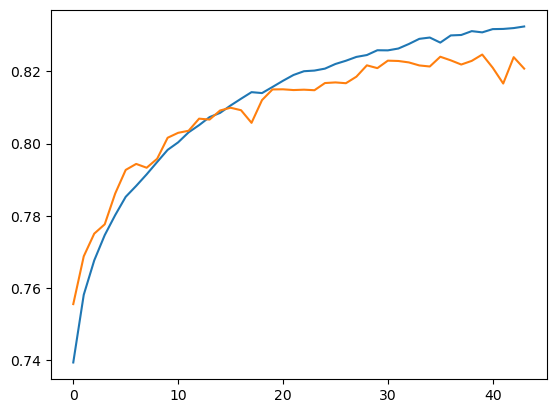

In [ ]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.show()

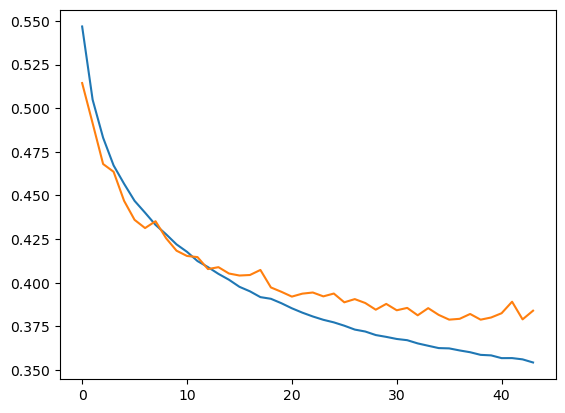

In [ ]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.show()

In [ ]:
#model = keras.Model(inputs=model.input, outputs=[model.output, model.get_layer('attention_vec').output])

In [ ]:
test_case_raw = 'print "Hello World"'
#test_case_raw = 'if 2==3: print "true" else: print "false"' 

In [ ]:
def predict_fn (code):
    predictions = []
    if isinstance(code, list) or isinstance(code, np.ndarray):
        m_input = code
    else:
        m_input = [code]
    
    for m in m_input:
        m_input = tokenizer.texts_to_sequences([m])
        m_input = pad_sequences(m_input, maxlen=MAX_SEQUENCE_LENGTH)
        prob = model.predict(m_input)
        predictions.append([1-prob[0][0], prob[0][0]])
    return np.array(predictions)



In [ ]:
predict_fn(test_case_raw)

1/1 [==============================] - 0s 57ms/step


array([[0.09340906, 0.90659094]])

In [ ]:
predict_fn(test_case_raw)[0,1]

1/1 [==============================] - 0s 23ms/step


0.9065909385681152

In [ ]:
#int(pl.predict_proba([test_case_raw])[0,1])

In [ ]:
#attention_outputs = outputs[1]

In [ ]:
#print(attention_outputs)